In [2]:
import sys
import time
import datetime
import os
import tensorflow as tf
import argparse
import json
import socket
from PIL import Image
from util import *
import numpy as np
%load_ext autoreload
%autoreload 2
# %matplotlib notebook
from copy import deepcopy
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from matplotlib.colors import hsv_to_rgb
from helpers import *

In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
logPath = "TRAINING/translation/"
snapshotPath = "SNAPSHOTS/snapshots/"

In [4]:
with open("hyperParams.json") as f:
    instanceParams = json.load(f)

instanceParams

{u'baseLR': 1e-05,
 u'batchSize': 2,
 u'borderThicknessH': 0.02,
 u'borderThicknessW': 0.02,
 u'boundaryAlpha': 6.5,
 u'dataset': u'kitti2012',
 u'flowScale': 20.0,
 u'gradParams': {u'robustness': 0.46, u'scale': 255.0, u'weight': 6.408},
 u'instanceName': u'unsupFlownet',
 u'iterations': 500000,
 u'lossComponents': {u'asymmetricSmooth': True,
  u'backward': False,
  u'boundaries': False,
  u'gradient': False,
  u'smooth2nd': False},
 u'multiscale': False,
 u'occlusion': False,
 u'photoParams': {u'robustness': 1.0, u'scale': 255.0},
 u'printFreq': 1000,
 u'resnet': False,
 u'segmentationConsistency': False,
 u'smooth2ndParams': {u'robustness': 0.21, u'scale': 1.0, u'weight': 0.53},
 u'smoothOccParams': {u'robustness': 0.9, u'scale': 1.8},
 u'smoothParams': {u'robustness': 1.0, u'scale': 1.0, u'weight': 10000.0},
 u'snapFreq': 5000,
 u'snapshotFreq': 20000,
 u'split': False,
 u'weightDecay': 0.0}

In [5]:
printFrequency = instanceParams["printFreq"]
batchSize = instanceParams["batchSize"]

iterations = instanceParams["iterations"]
baseLearningRate = instanceParams["baseLR"]
learningRate = baseLearningRate
snapshotFrequency = instanceParams["snapshotFreq"]

from dotmap import DotMap
arg = DotMap()
arg.logDev = False
arg.resume = 'n'
resume, startIteration, snapshotFiles = checkResume(snapshotPath,logPath, arg)

resuming from iteration 501000


In [6]:
# from matplotlib import image as mpimg
# from PIL import Image
# im1 = mpimg.imread("../example_data/data/DAVIS/JPEGImages/480p/bus/00023.jpg")
# plt.imshow(im1)
# from scipy.ndimage import map_coordinates
# def warp(im, uv):
#     H, W, C = im.shape
#     x, y = np.meshgrid(range(W), range(H))
#     x, y = x.astype(np.float32), y.astype(np.float32)
#     x2 = x + uv[:,:,0]
#     y2 = y + uv[:,:,1]

#     return np.dstack([
#         map_coordinates(im[:,:,i], [y2.ravel(), x2.ravel()], mode='mirror').reshape((H, W)) for i in range(C)
#     ])
# motion = np.zeros((480, 854, 2))
# motion[:,:,0] += 5
# warpim = warp(im1, motion)
# im2 = Image.fromarray(warpim)
# im2.save('bus_translate.jpg')

### Training

In [7]:
with tf.device("/gpu:0"):
    trainingData = TrainingData(batchSize,instanceParams)

with tf.device("/gpu:0"):
    # init
    with tf.variable_scope("netShare"):
        networkBodyF = NetworkBody(trainingData,instanceParams)
    with tf.variable_scope("netShare",reuse=True):
        networkBodyB = NetworkBody(trainingData,instanceParams,flipInput=True)

    trainingLoss = TrainingLoss(instanceParams,networkBodyF,networkBodyB,trainingData)
    solver, solver_op, learningRateTensor = attachSolver(trainingLoss.loss)
    flowFinal = networkBodyF.flows[0]
    tGrad = tf.gradients(trainingLoss.loss, flowFinal)
    # loss scheduling
    recLossBWeightTensor = trainingLoss.recLossBWeight

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


Reading Tensor("ImagePairData/image_data_reader/Placeholder:0", dtype=string, device=/device:GPU:0)
Reading Tensor("ImagePairData/image_data_reader_1/Placeholder:0", dtype=string, device=/device:GPU:0)
Reading Tensor("ImagePairData/image_data_reader_2/Placeholder:0", dtype=string, device=/device:GPU:0)
Reading Tensor("ImagePairData/image_data_reader_3/Placeholder:0", dtype=string, device=/device:GPU:0)


HELLO


In [8]:
# merge summaries
merged = tf.summary.merge_all()
# saver
saver = tf.train.Saver(max_to_keep=0)

In [9]:
printFrequency = 10
snapshotFrequency = 1000
iterations = 2020
startIteration = 0
print(printFrequency)
print(snapshotFrequency)
print(iterations)
print(startIteration)

10
1000
2020
0


In [10]:
f1s = []
f2s = []
f3s = []
f4s = []
f5s = []
tgs = []
with sessionSetup(arg) as sess:
    saver.restore(sess,
                   '../model_download_scripts/photometric_smoothness/weights/iter_0000000000500000.ckpt')

    # sess.run(tf.initialize_all_variables())
    # saver.restore(sess, './snapshots/iter_0000000000005000.ckpt')
    trainingData.dataQueuer.start_queueing(sess)

    #start summary writer
    summary_writer = tf.summary.FileWriter(logPath, sess.graph)

    #run
    lastPrint = time.time()
    for i in range(startIteration, startIteration + iterations + 10):
        # scheduled values
        learningRate = learningRateSchedule(baseLearningRate, i)
        recLossBWeight = unsupLossBSchedule(i)

         #run training
        feed_dict = {
            learningRateTensor: 1e-5
        }
        summary,result,totalLoss, f1, tg = sess.run([
            merged,solver_op,trainingLoss.loss, flowFinal, tGrad], feed_dict=feed_dict)

        if (i+1) % printFrequency == 0:
            timeDiff = time.time() - lastPrint
            itPerSec = printFrequency/timeDiff
            remainingIt = startIteration + iterations + 10 - i
            eta = remainingIt/itPerSec
            print("Iteration "+str(i+1)+": loss: "+str(totalLoss)+", iterations per second: "+str(
                itPerSec)+", ETA: "+str(datetime.timedelta(seconds=eta)))+", lr: "+str(learningRate)

            summary_writer.add_summary(summary,i+1)
            summary_writer.flush()
            lastPrint = time.time()
            f1s.append(deepcopy(f1))
            tgs.append(deepcopy(tg[0]))
            # f2s.append(deepcopy(f2))

        if (i+1) % snapshotFrequency == 0:
            saver.save(sess,"snapshots/iter_"+str(i+1).zfill(16)+".ckpt")

        sys.stdout.flush()

    trainingData.dataQueuer.close(sess)

INFO:tensorflow:Restoring parameters from ../model_download_scripts/photometric_smoothness/weights/iter_0000000000500000.ckpt
Iteration 10: loss: [[991.29663]
 [991.29663]], iterations per second: 0.778478980883, ETA: 0:43:16.088076, lr: 1e-05
Iteration 20: loss: [[840.6494 ]
 [840.64935]], iterations per second: 1.66558653624, ETA: 0:20:07.382478, lr: 1e-05
Iteration 30: loss: [[759.3164]
 [759.3164]], iterations per second: 1.66352732025, ETA: 0:20:02.865727, lr: 1e-05


Exception in thread Thread-9:
Traceback (most recent call last):
  File "/home/y788zhang/.conda/envs/p27/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/home/y788zhang/.conda/envs/p27/lib/python2.7/threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "util/data_input/DataQueuer.py", line 88, in thread_main
    exit()
NameError: global name 'exit' is not defined

Exception in thread Thread-11:
Traceback (most recent call last):
  File "/home/y788zhang/.conda/envs/p27/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/home/y788zhang/.conda/envs/p27/lib/python2.7/threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "util/data_input/DataQueuer.py", line 88, in thread_main
    exit()
NameError: global name 'exit' is not defined
Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/y788zhang/.conda/envs/p27/lib/python2.7/threading

KeyboardInterrupt: 

max flow: 9.8584
flow range:
u = -3.570 .. 9.370
v = -4.008 .. 0.601


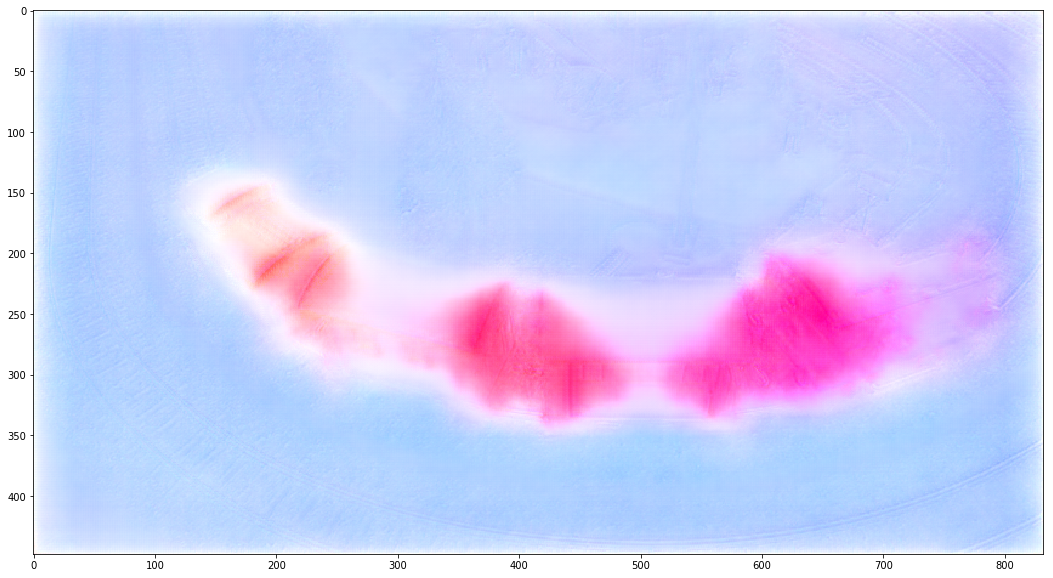

In [12]:
plt.figure(figsize=(20,10))
plt.imshow(flow_to_image(f1s[0][0]))

max flow: 11.3137
flow range:
u = -5.135 .. 8.000
v = -8.000 .. 4.365


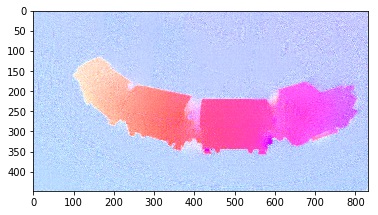

In [30]:
plt.imshow(flow_to_image(np.clip(f1s[-1][0], -8, 8)))

In [12]:
from scipy.ndimage import map_coordinates
from scipy.ndimage.filters import convolve
def photo_loss(im1, im2, uv):
    return np.mean(np.sum(np.square(warp(im2, uv) - im1), axis=-1))

def warp(im, uv):
    H, W, C = im.shape
    x, y = np.meshgrid(range(W), range(H))
    x, y = x.astype(np.float32), y.astype(np.float32)
    x2 = x + uv[:,:,0]
    y2 = y + uv[:,:,1]

    return np.dstack([
        map_coordinates(im[:,:,i], [y2.ravel(), x2.ravel()], mode='mirror').reshape((H, W)) for i in range(C)
    ])
def smooth_loss(u, v, gt):    
    gt_kernels = [[[0,0,0],
               [0,1,-1],
               [0,0,0]],
              [[0,-1,0],
               [0,1,0],
               [0,0,0]],
              [[0,0,0],
               [-1,1,0],
               [0,0,0]],
              [[0,0,0],
               [0,1,0],
               [0,-1,0]]]
    
    udx = convolve(u, gt_kernels[0]) * (1 - convolve(gt, gt_kernels[0]) ** 2)
    udy = convolve(u, gt_kernels[1]) * (1 - convolve(gt, gt_kernels[1]) ** 2)
    vdx = convolve(v, gt_kernels[0]) * (1 - convolve(gt, gt_kernels[0]) ** 2)
    vdy = convolve(v, gt_kernels[1]) * (1 - convolve(gt, gt_kernels[1]) ** 2)

    ret = udx**2 + udy**2 + vdx**2 + vdy**2
    return np.mean(ret[1:-1,1:-1])

In [13]:
from matplotlib import image as mpimg

In [14]:
im1 = mpimg.imread("../example_data/data/DAVIS/JPEGImages/480p/train/00023.jpg").astype(np.float32)[16:-16,11:-11,:]
im2 = mpimg.imread("../example_data/data/DAVIS/JPEGImages/480p/train/00024.jpg").astype(np.float32)[16:-16,11:-11,:]
gt = mpimg.imread("../example_data/data/DAVIS/Annotations/480p/train/00023.png")[16:-16,11:-11]

In [15]:
pLoss, sLoss = [], []
for i in range(len(f1s)):
    print(i)
    pLoss.append(np.mean(photo_loss(im1, im2, f1s[i][0])))
    sLoss.append(np.mean(smooth_loss(f1s[i][0][:,:,0], f1s[i][0][:,:,1], gt)))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [24]:
pLoss

array([374.19586, 319.72205, 278.08963, 253.24568, 239.05869, 228.94414,
       221.61026, 215.43785, 210.24484, 205.94926, 202.10558, 198.78563,
       195.93333, 193.31139, 190.92992, 188.75975, 186.76674, 184.91174,
       183.14299, 181.49805, 179.9747 , 178.51665, 177.17537, 175.90239,
       174.67606, 173.50874, 172.35571, 171.27725, 170.34265, 169.27306,
       168.3178 ], dtype=float32)

In [25]:
sLoss

array([0.10381323, 0.09895822, 0.0953119 , 0.09708   , 0.09424017,
       0.09343499, 0.09179853, 0.09071649, 0.09006764, 0.08915824,
       0.08847557, 0.08767187, 0.08676219, 0.08615724, 0.08554456,
       0.08496885, 0.0843691 , 0.08385655, 0.0834718 , 0.08310796,
       0.08270743, 0.08236578, 0.08191954, 0.08158135, 0.08124296,
       0.08093581, 0.08063183, 0.08036172, 0.08000792, 0.0798135 ,
       0.07949366], dtype=float32)

In [21]:
pLoss = np.array(pLoss)
sLoss = np.array(sLoss)
tLoss = pLoss + 10000 * sLoss

In [22]:
tLoss

array([394.9585 , 339.5137 , 297.152  , 272.66168, 257.9067 , 247.63113,
       239.96997, 233.58115, 228.25838, 223.78091, 219.80069, 216.32   ,
       213.28577, 210.54283, 208.03883, 205.75352, 203.64056, 201.68306,
       199.83736, 198.11964, 196.51619, 194.9898 , 193.55928, 192.21866,
       190.92465, 189.6959 , 188.48209, 187.3496 , 186.34424, 185.23576,
       184.21652], dtype=float32)

In [36]:
tLoss = [512.13007, 415.7069 , 405.75858, 387.3759 , 374.62695, 370.07803,
       365.17737, 361.14453, 358.74344, 357.33612, 357.10867, 354.6288 ,
       354.8871 , 356.4079 , 357.10217, 356.2941 , 357.71854, 358.13428,
       357.899  , 357.4205 , 356.99692, 357.17236, 356.66577, 356.72113,
       355.37347, 355.5998 , 355.63974, 354.83774, 353.2046 , 353.7557 ,
       354.0131 , 354.18503, 353.7424 , 353.71628, 354.1426 , 353.01004,
       353.61664, 352.85718, 353.58688, 353.25293, 353.04474, 353.6151 ,
       352.78513, 353.15192, 354.34955, 352.39798, 352.36234, 352.4784 ,
       352.8396 , 352.87387, 354.27283, 352.44183, 351.65747, 352.14587,
       352.23425, 353.17523, 351.01517, 351.79315, 352.31174, 352.07663,
       352.29654, 352.28204, 352.74738, 351.52194, 351.69666, 351.8264 ,
       352.73087, 351.11798, 350.37985, 351.88086, 351.26035, 351.74286,
       351.44354, 351.5248 , 352.34415, 350.50662, 351.1715 , 351.6849 ,
       352.00052, 351.5119 , 351.8541 , 353.36563, 351.55368, 351.88745,
       351.92596, 351.9155 , 351.7767 , 351.71063, 350.98218, 351.4109 ,
       351.786  , 351.3501 , 351.93115, 352.2041 , 348.85846, 352.2875 ,
       350.5494 , 352.35806, 351.15033, 351.5424 , 351.67258, 351.54855,
       351.61212, 351.8291 , 351.5091 , 351.37006, 351.4598 , 352.2522 ,
       351.95566, 350.79468, 351.351  , 351.05975, 351.28592, 350.06085,
       351.749  , 350.76465, 351.09448, 351.1985 , 351.98264, 352.65283,
       350.918  , 351.2374 , 351.05206, 350.98166, 349.7025 , 350.85477,
       350.96744, 351.08258, 350.99353, 350.90735, 350.11462, 351.69305,
       351.69568, 350.7414 , 351.0843 , 351.02197, 350.6358 , 348.96896,
       351.0345 , 351.5888 , 351.47723, 351.42868, 351.38922, 352.1159 ,
       350.11932, 351.85147, 351.36792, 351.44308, 350.81744, 350.7976 ,
       349.46844, 352.26572, 350.26025, 350.84506, 351.22937, 351.0414 ,
       350.83282, 351.0077 , 351.77325, 350.38687, 351.31836, 350.73154,
       350.69223, 350.74948, 353.13272, 349.16302, 350.35345, 350.5488 ,
       350.36783, 350.4886 , 350.4851 , 350.49313, 350.53873, 350.8238 ,
       351.37115, 349.97772, 350.6912 , 350.60114, 352.14398, 349.80655,
       348.9935 , 349.8288 , 349.7547 , 350.24365, 350.81952, 352.3584 ,
       349.03552, 350.1056 , 350.22388, 350.156  , 349.8379 , 350.3454 ,
       351.58374, 349.2976 , 350.89246, 350.29248, 350.14465, 349.90985,
       349.31683, 347.29248, 349.38223, 348.96298, 349.44583]

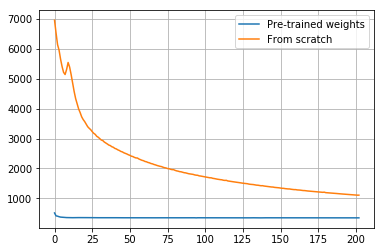

In [37]:
# lambda = 1000
plt.plot(tLoss, label='Pre-trained weights')
plt.plot(tLoss_scratch, label='From scratch')
plt.grid()
plt.legend(loc='upper right')
# 1108.226
# 349.44583

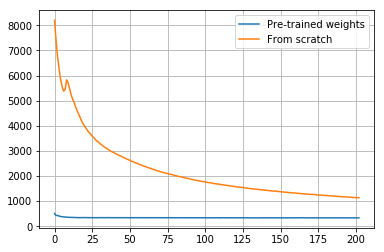

In [38]:
# lambda = 200
plt.plot(tLoss, label='Pre-trained weights')
plt.plot(tLoss_scratch, label='From scratch')
plt.grid()
plt.legend(loc='upper right')
# 1136.9403
# 333.632

### Testing

In [ ]:
datasetRoot = '../example_data/'
frame0Path = '../example_data/datalists/train_im0.txt'
frame1Path = '../example_data/datalists/train_im1.txt'
gt0Path = '../example_data/datalists/train_gt0.txt'
desiredHeight = 480
desiredWidth = 854

In [ ]:
with open(frame0Path) as f:
    imagePairs0 = [datasetRoot+x[:-1] for x in f.readlines()]
with open(frame1Path) as f:
    imagePairs1 = [datasetRoot+x[:-1] for x in f.readlines()]
with open(gt0Path) as f:
    gtPairs1 = [datasetRoot+x[:-1] for x in f.readlines()]

In [ ]:
imagePairs0 = [item for item in imagePairs0 if 'bus' in item]
imagePairs1 = [item for item in imagePairs1 if 'bus' in item]
gtPairs1 = [item for item in gtPairs1 if 'bus' in item]

In [ ]:
testData = TestData(imagePairs0,imagePairs1,gtPairs1,1,desiredHeight,desiredWidth)

In [ ]:
with tf.device("/gpu:0"):
    with tf.variable_scope("netShare"):
        networkBody = NetworkBody(testData,instanceParams)
    flowFinal = networkBody.flows[0]

In [ ]:
flowViz = flowToRgb(flowFinal)
transformGrid = flowTransformGrid(flowFinal)
mean = tf.expand_dims(tf.expand_dims(tf.expand_dims([0.407871, 0.457525, 0.481094], 0), 0), 0)

In [ ]:
saver = tf.train.Saver()

# config tensorflow
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True

In [ ]:
test_length = 70
start = 0
result_dir = 'results'
iterations = 515000

flows = []
viz = []
gradients = []
ground_truths = []
arrs = []
with tf.Session(config=config) as sess:
    saver.restore(sess,"snapshots/iter_0000000000002000.ckpt")

    # run
    lastPrint = time.time()
    for i in range(start, start + min(test_length, len(imagePairs0))):
        feed_dict = {
            testData.im0File: imagePairs0[i],
            testData.im1File: imagePairs1[i],
            testData.gt0File: gtPairs1[i]
        }
        hsv, f = sess.run([flowViz, flowFinal],feed_dict=feed_dict)

        flows.append(deepcopy(f))
        h, w = 448, 532
        arr = np.maximum(np.minimum(np.asarray(hsv),1), 0)
        arr = np.squeeze(np.asarray(arr*255,np.uint8))
        arrs.append(deepcopy(arr[:h,:w,:]))
        im = Image.fromarray(arr[:h,:w,:])
        viz.append(deepcopy(im))
        # im.save("{}/{}.png".format(result_dir, str(i).zfill(3)))

In [ ]:
flows.shape

In [ ]:
flows = np.array(flows)
arrs = np.array(arrs)

In [ ]:
plt.imshow(flow_to_image(flows[23]))